## Introduction

In the realm of drug discovery, small molecule drugs interact with proteins within cells to modulate biological functions, often by inhibiting specific proteins implicated in disease processes. Traditionally, identifying candidate molecules that bind to protein targets involves synthesizing them individually and testing their interactions—a time-consuming and laborious process. Given that the FDA has approved only about 2,000 novel molecular entities, compared to an estimated 10^60 potential drug-like molecules, there is a clear need for more efficient methods to explore this vast chemical space.

The BELKA dataset, provided by Leash Biosciences, offers a unique opportunity to leverage machine learning to predict the binding affinities of small molecules to specific protein targets. By employing advanced ML techniques, this project aims to revolutionize the search for effective treatments hidden within the expansive chemical space, accelerating the drug discovery process and potentially uncovering new lifesaving medicines.

### Understanding the Application Problem

#### Data Types

1. **Chemical Structures**: Represented as SMILES (Simplified Molecular-Input Line-Entry System) strings, detailing the composition of small molecules at various stages:
   - **Building Blocks**: SMILES representations for the first, second, and third building blocks of the molecule.
   - **Full Molecule**: A complete SMILES representation of the fully assembled molecule, including the building blocks and a triazine core with a DNA linker.

2. **Protein Information**:
   - **Protein Target Name**: Identifies which of the three protein targets (EPHX2, BRD4, ALB) the molecule is tested against.

3. **Response Variable**:
   - **Binding Label (`binds`)**: A binary classification (0 or 1) indicating whether the molecule binds to the protein target. This is the response variable and is only available in the training dataset.

#### Data Source

- **BELKA Dataset**: Generated by Leash Biosciences using DNA-encoded chemical library (DEL) technology, comprising approximately 133 million small molecules tested against three protein targets. The dataset includes roughly 98 million training examples per protein, with separate validation and test sets that incorporate novel building blocks not present in the training data to assess model generalizability.

#### Explanatory Variables

- **Molecular SMILES**: Used to predict the binding potential of the molecules.
- **Building Block SMILES**: Provide information on the constituent parts of the full molecule, potentially relevant for understanding binding interactions.
- **Protein Target Name**: Helps differentiate the context of binding predictions as each protein has unique structural and functional characteristics that influence binding.

### Application Problem

The task is to build predictive models that estimate the likelihood of small molecules binding to specific protein targets. This involves understanding how chemical structures (represented by SMILES) interact with the proteins EPHX2 (sEH), BRD4, and ALB. The challenge is amplified by the highly imbalanced nature of the dataset, where only about 0.5% of molecules are classified as binders.

### Approach

1. **Preprocessing and Feature Engineering**:
   - Convert SMILES strings into numerical features using cheminformatics tools like RDKit. Techniques include generating molecular fingerprints, descriptors, or embeddings that can be fed into machine learning models.
   - Incorporate protein structural information, such as sequence data or 3D structures, which may enhance the models' understanding of binding contexts.

2. **Model Development**:
   - Begin with baseline models (e.g., logistic regression, random forests) to establish a performance benchmark.
   - Progress to more advanced models like neural networks (CNNs, RNNs), graph neural networks, or transformer-based architectures tailored for SMILES data.

3. **Handling Imbalanced Data**:
   - Use techniques such as oversampling, undersampling, or algorithm-specific adjustments (e.g., class weights) to address the severe class imbalance.
   - Evaluate models with metrics that are robust to imbalance, such as precision-recall AUC, F1 score, or Matthews correlation coefficient.

4. **Evaluation and Validation**:
   - Implement stratified k-fold cross-validation to ensure that the evaluation metrics reflect the model's ability to generalize across the imbalanced classes.
   - Test generalizability on the provided test set, which includes molecules with novel building blocks not seen in the training data, to simulate real-world conditions.


This project aims to contribute to the advancement of computational drug discovery by leveraging the BELKA dataset to predict small molecule binding to protein targets. By employing sophisticated machine learning models and tackling the challenges of data imbalance and generalizability, the resulting predictive models have the potential to significantly accelerate the identification of promising drug candidates, democratizing aspects of drug discovery and aiding in the development of new therapies.

In [5]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import io
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage

import warnings
warnings.filterwarnings('ignore')

In [18]:
con = duckdb.connect(database=':memory:')

parquet_file_path = 'train.parquet/train.parquet'

sample_size = 1000000

con.execute(f"CREATE TABLE train_sample AS SELECT * FROM read_parquet('{parquet_file_path}') USING SAMPLE {sample_size} ROWS")

df_sample = con.execute("SELECT * FROM train_sample LIMIT 5").fetchdf()
print("Initial Rows from the Sample Dataset:")
print(df_sample)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Initial Rows from the Sample Dataset:
          id                              buildingblock1_smiles  \
0  201874889      O=C(Nc1ccc(F)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21   
1   61095530  Cc1ccccc1[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2c...   
2  220390637       O=C(Nc1cncc(C(=O)O)n1)OCC1c2ccccc2-c2ccccc21   
3   64098321  N#Cc1ccc(C[C@@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3...   
4  279894240     O=C(O)[C@@H]1CCCCN1C(=O)OCC1c2ccccc2-c2ccccc21   

              buildingblock2_smiles  buildingblock3_smiles  \
0              CSCc1nnc(CN)[nH]1.Cl          CCS(=O)CCN.Cl   
1                     CC1CCCC(CN)O1  Nc1cc2cccnc2c2ncccc12   
2                  CS(=O)C1(CN)CCC1         Cc1cccc(N)c1Cl   
3                 Nc1ccc(F)c(Cl)c1F     Nc1cc(F)c(F)c(F)c1   
4  Nc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O           Cc1cc(N)nn1C   

                                     molecule_smiles protein_name  binds  
0  CCS(=O)CCNc1nc(NCc2nnc(CSC)[nH]2)nc(Nc2ccc(F)c...          sEH      0  
1  Cc1ccccc1[C@@H](CC(=O)N[Dy])Nc1nc

In [3]:
# Overview of data types and basic information
print("\nColumn Information:")
columns_info = con.execute("DESCRIBE train_sample").fetchdf()
print(columns_info)


Column Information:
             column_name column_type null   key default extra
0                     id      BIGINT  YES  None    None  None
1  buildingblock1_smiles     VARCHAR  YES  None    None  None
2  buildingblock2_smiles     VARCHAR  YES  None    None  None
3  buildingblock3_smiles     VARCHAR  YES  None    None  None
4        molecule_smiles     VARCHAR  YES  None    None  None
5           protein_name     VARCHAR  YES  None    None  None
6                  binds      BIGINT  YES  None    None  None


In [4]:
# Summary statistics for numerical variables in the sample
print("\nSummary Statistics:")
summary_stats = con.execute("SELECT * FROM train_sample").fetchdf().describe()
print(summary_stats)


Summary Statistics:
                 id          binds
count  1.000000e+05  100000.000000
mean   1.473787e+08       0.005160
std    8.520179e+07       0.071648
min    1.036000e+03       0.000000
25%    7.410697e+07       0.000000
50%    1.467589e+08       0.000000
75%    2.211598e+08       0.000000
max    2.952442e+08       1.000000


In [5]:
print("\nMissing Values Analysis in Sample:")
missing_values_sample = con.execute("""
    SELECT
        column_name,
        COUNT(*) AS total_rows,
        SUM(CASE WHEN column_value IS NULL THEN 1 ELSE 0 END) AS missing_count,
        SUM(CASE WHEN column_value IS NULL THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS missing_percentage
    FROM
        train_sample,
        LATERAL unnest(ARRAY[buildingblock1_smiles, buildingblock2_smiles]) AS column_value(column_name)
    GROUP BY column_name
    ORDER BY missing_percentage DESC;
""").fetchdf()
print(missing_values_sample)


Missing Values Analysis in Sample:
                                           column_name  total_rows  \
0                  O=C(O)CNC(=O)OCC1c2ccccc2-c2ccccc21         405   
1                                       N#CC1=C(N)CCC1          70   
2    O=C(N[C@H](Cc1csc2ccccc12)C(=O)O)OCC1c2ccccc2-...         352   
3    O=C(O)C[C@@H](Cc1ccccc1Cl)NC(=O)OCC1c2ccccc2-c...         378   
4                                      COc1cccc(F)c1CN         140   
..                                                 ...         ...   
959                                 Cl.NCC1OCCc2ccsc21          73   
960                                   Cl.NCc1cnc(Cl)s1          53   
961                             Nc1cc(-c2ccccc2)[nH]n1          66   
962                                  Cl.NCC1CC12CCOCC2          77   
963                         CC1(C)NC(=O)N(CCCN)C1=O.Cl          52   

     missing_count  missing_percentage  
0              0.0                 0.0  
1              0.0                 0.0  



Target Variable Distribution in Sample:
   binds  count
0      0  99484
1      1    516


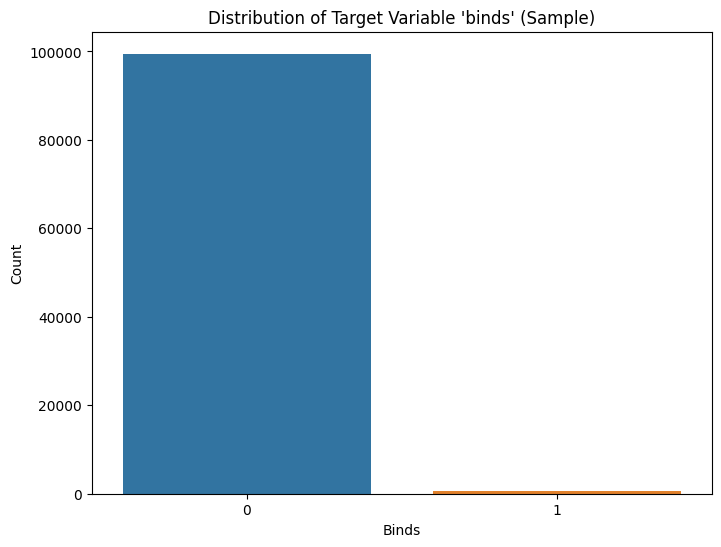

In [6]:
binds_distribution_sample = con.execute("SELECT binds, COUNT(*) AS count FROM train_sample GROUP BY binds").fetchdf()
print("\nTarget Variable Distribution in Sample:")
print(binds_distribution_sample)

plt.figure(figsize=(8, 6))
sns.barplot(data=binds_distribution_sample, x='binds', y='count')
plt.title("Distribution of Target Variable 'binds' (Sample)")
plt.ylabel("Count")
plt.xlabel("Binds")
plt.show()


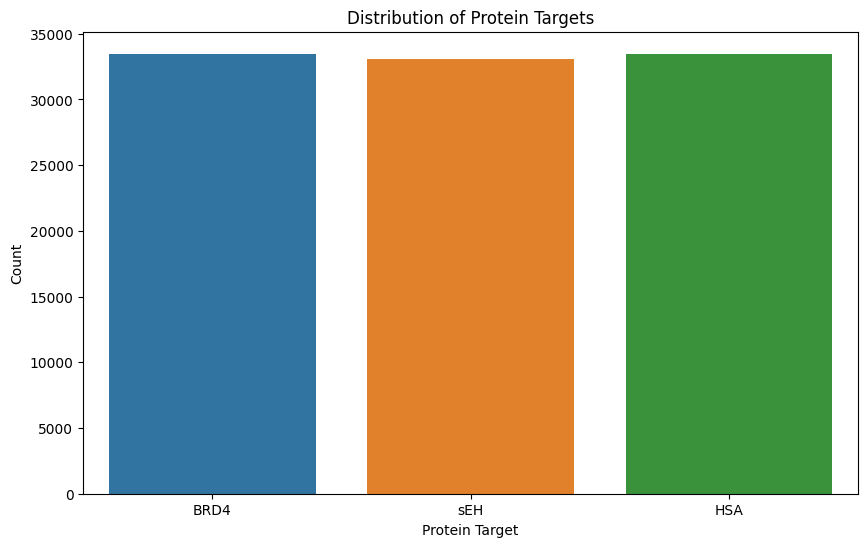

In [7]:
df = con.execute("SELECT * FROM train_sample").df()

plt.figure(figsize=(10, 6))
sns.countplot(x='protein_name', data=df)
plt.title('Distribution of Protein Targets')
plt.xlabel('Protein Target')
plt.ylabel('Count')
plt.show()

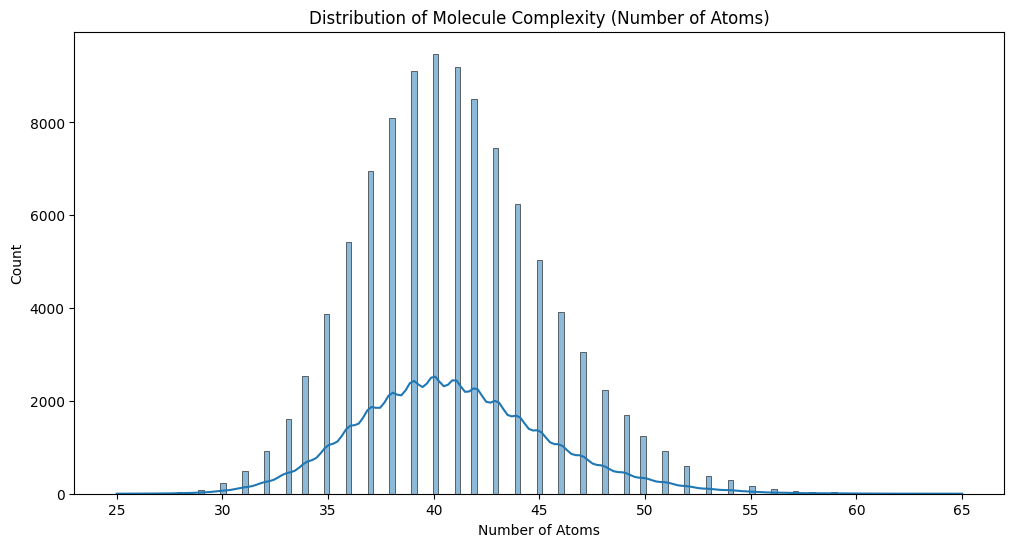

In [8]:
df['num_atoms'] = df['molecule_smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='num_atoms', kde=True)
plt.title('Distribution of Molecule Complexity (Number of Atoms)')
plt.xlabel('Number of Atoms')
plt.ylabel('Count')
plt.show()

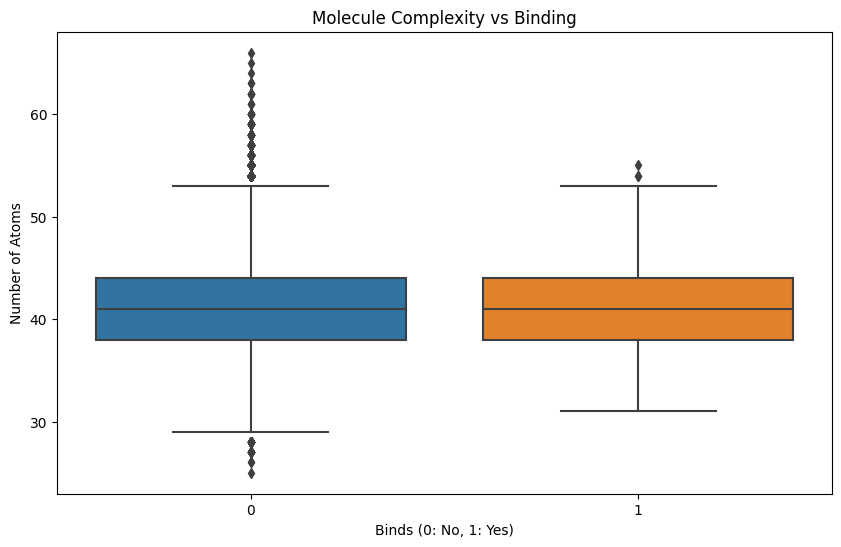

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='binds', y='num_atoms', data=df)
plt.title('Molecule Complexity vs Binding')
plt.xlabel('Binds (0: No, 1: Yes)')
plt.ylabel('Number of Atoms')
plt.show()

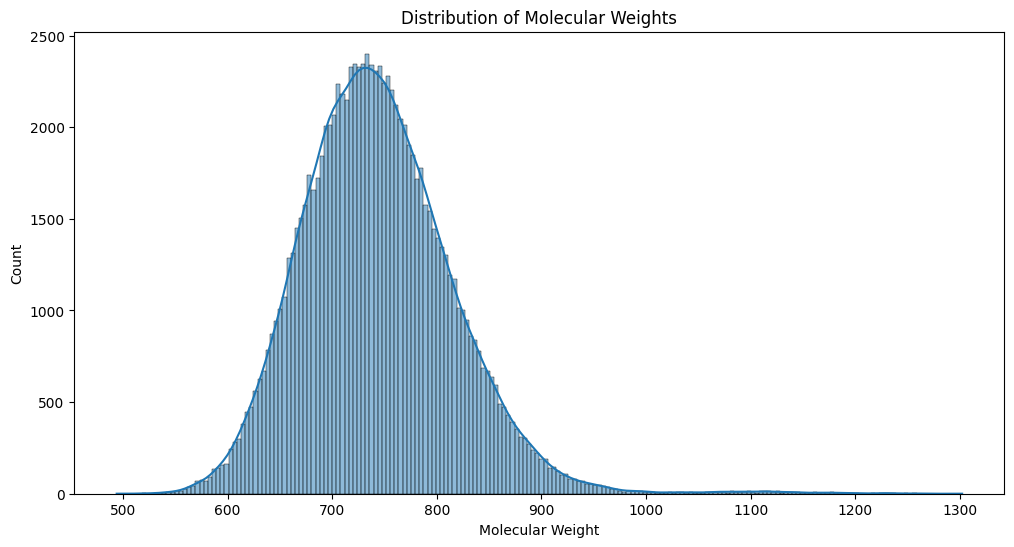

In [9]:
df['mol_weight'] = df['molecule_smiles'].apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='mol_weight', kde=True)
plt.title('Distribution of Molecular Weights')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.show()

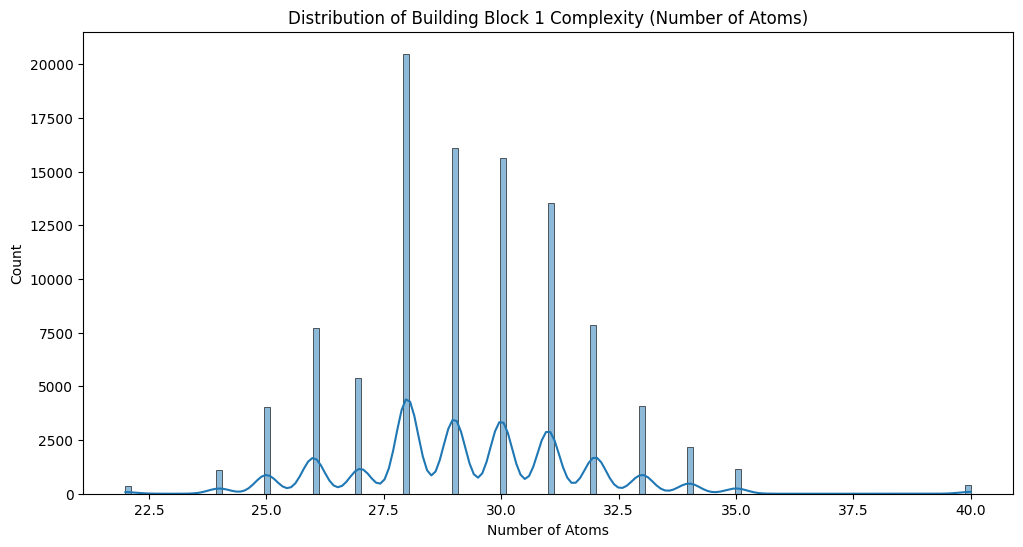

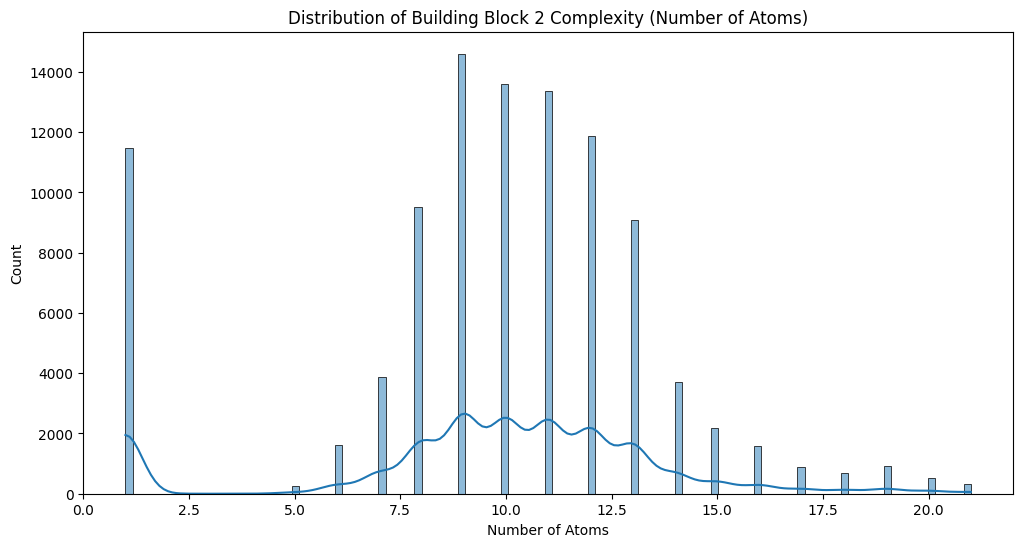

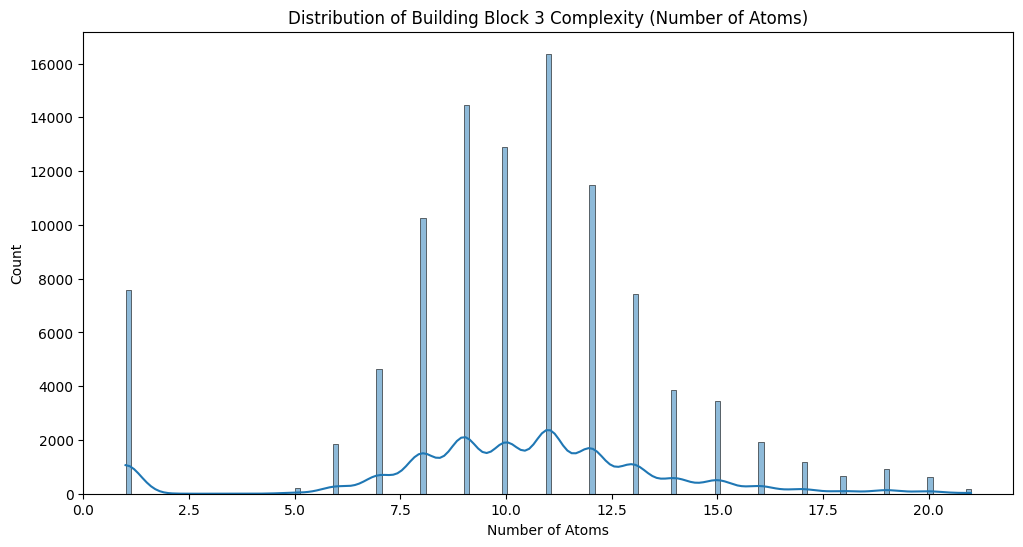

In [17]:
for i in range(1, 4):
    plt.figure(figsize=(12, 6))
    df[f'bb{i}_atoms'] = df[f'buildingblock{i}_smiles'].apply(lambda x: Chem.MolFromSmiles(x.split('.')[-1]).GetNumAtoms())
    sns.histplot(data=df, x=f'bb{i}_atoms', kde=True)
    plt.title(f'Distribution of Building Block {i} Complexity (Number of Atoms)')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Count')
    plt.show()

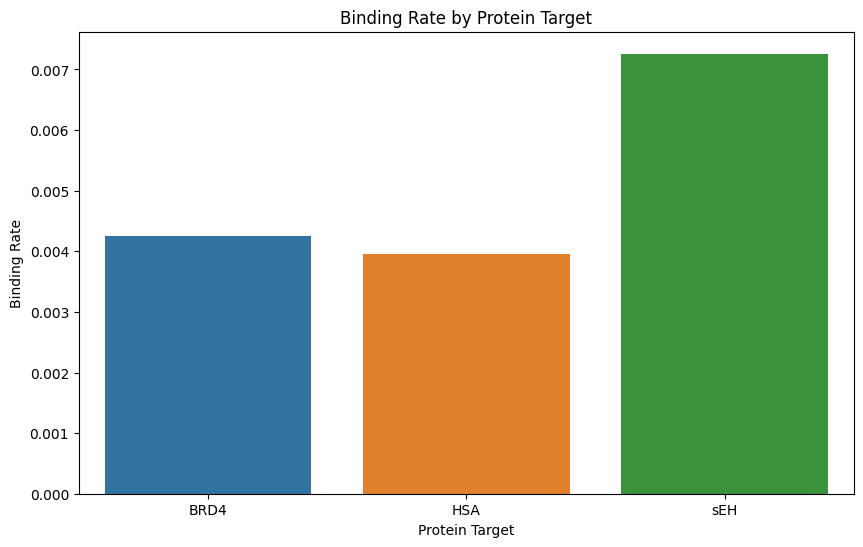

In [10]:
binding_rate = df.groupby('protein_name')['binds'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='protein_name', y='binds', data=binding_rate)
plt.title('Binding Rate by Protein Target')
plt.xlabel('Protein Target')
plt.ylabel('Binding Rate')
plt.show()

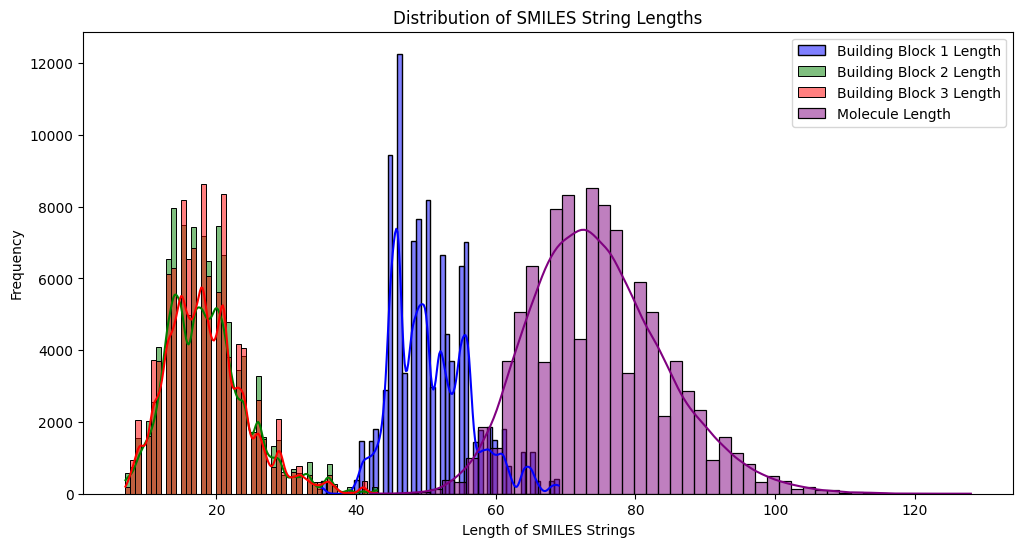

In [26]:
smiles_query = """
SELECT 
    LENGTH(buildingblock1_smiles) AS buildingblock1_length,
    LENGTH(buildingblock2_smiles) AS buildingblock2_length,
    LENGTH(buildingblock3_smiles) AS buildingblock3_length,
    LENGTH(molecule_smiles) AS molecule_length
FROM train_sample
"""
smiles_lengths = con.execute(smiles_query).df()

# Plotting lengths of SMILES strings
plt.figure(figsize=(12, 6))
sns.histplot(smiles_lengths['buildingblock1_length'], bins=50, color='blue', label='Building Block 1 Length', kde=True)
sns.histplot(smiles_lengths['buildingblock2_length'], bins=50, color='green', label='Building Block 2 Length', kde=True)
sns.histplot(smiles_lengths['buildingblock3_length'], bins=50, color='red', label='Building Block 3 Length', kde=True)
sns.histplot(smiles_lengths['molecule_length'], bins=50, color='purple', label='Molecule Length', kde=True)
plt.title('Distribution of SMILES String Lengths')
plt.xlabel('Length of SMILES Strings')
plt.ylabel('Frequency')
plt.legend()
plt.show()

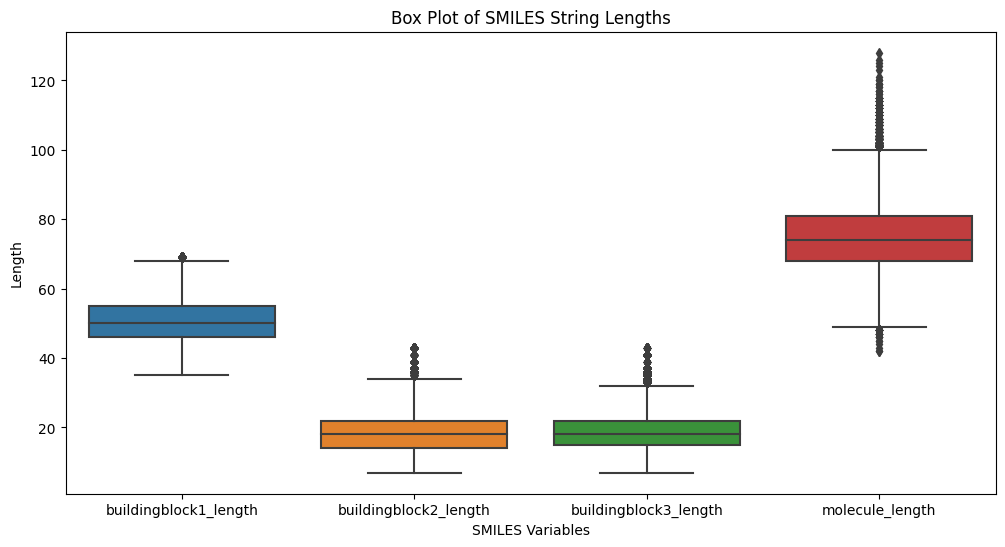

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=smiles_lengths[['buildingblock1_length', 'buildingblock2_length', 'buildingblock3_length', 'molecule_length']])
plt.title('Box Plot of SMILES String Lengths')
plt.ylabel('Length')
plt.xlabel('SMILES Variables')
plt.show()

## Molecules

In [28]:
def visualize_and_save_molecules(smiles_list, labels, filename):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=labels)
    pil_img = Image.open(io.BytesIO(img.data))
    pil_img.save(filename)

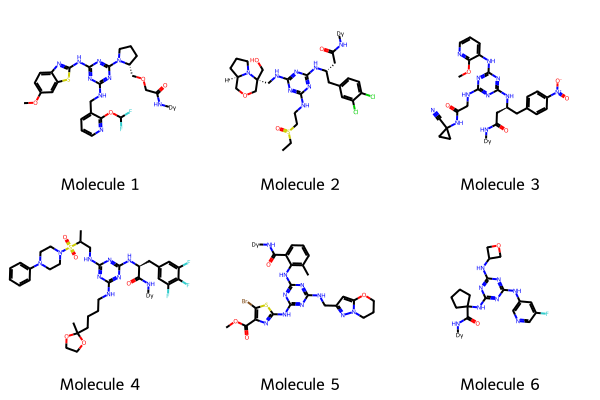

Example Molecules (First 6)


In [40]:
def visualize_and_display_molecules(smiles_list, labels, title):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=labels)
    display(IPImage(data=img.data, format='png'))
    print(title)

# 1. Original example molecules (first 6)
example_mols = df['molecule_smiles'].head(6).tolist()
example_labels = [f"Molecule {i+1}" for i in range(6)]
visualize_and_display_molecules(example_mols, example_labels, "Example Molecules (First 6)")


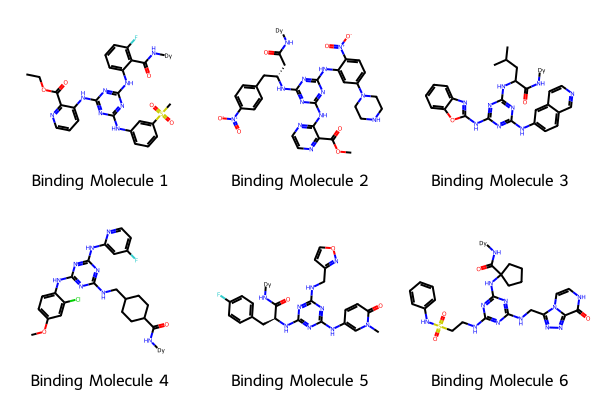

Binding Molecules (First 6)


In [41]:
binding_mols = df[df['binds'] == 1]['molecule_smiles'].head(6).tolist()
binding_labels = [f"Binding Molecule {i+1}" for i in range(6)]
visualize_and_display_molecules(binding_mols, binding_labels, "Binding Molecules (First 6)")


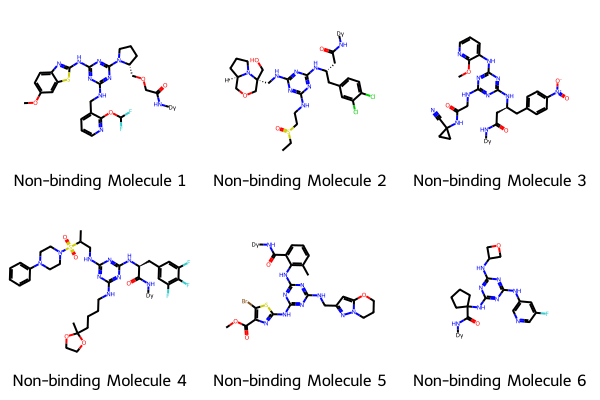

Non-binding Molecules (First 6)


In [42]:
non_binding_mols = df[df['binds'] == 0]['molecule_smiles'].head(6).tolist()
non_binding_labels = [f"Non-binding Molecule {i+1}" for i in range(6)]
visualize_and_display_molecules(non_binding_mols, non_binding_labels, "Non-binding Molecules (First 6)")

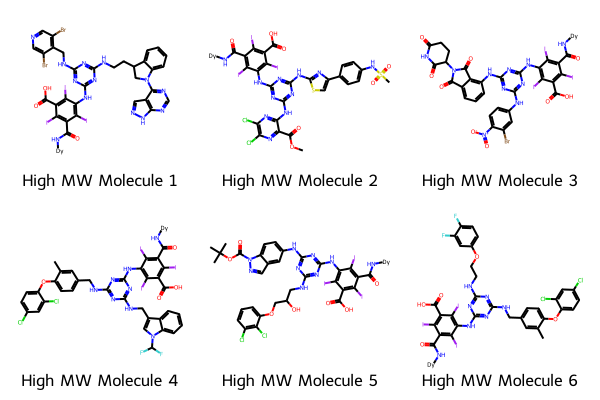

High Molecular Weight Molecules (Top 6)


In [43]:
df['mol_weight'] = df['molecule_smiles'].apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))
high_weight_mols = df.nlargest(6, 'mol_weight')['molecule_smiles'].tolist()
high_weight_labels = [f"High MW Molecule {i+1}" for i in range(6)]
visualize_and_display_molecules(high_weight_mols, high_weight_labels, "High Molecular Weight Molecules (Top 6)")

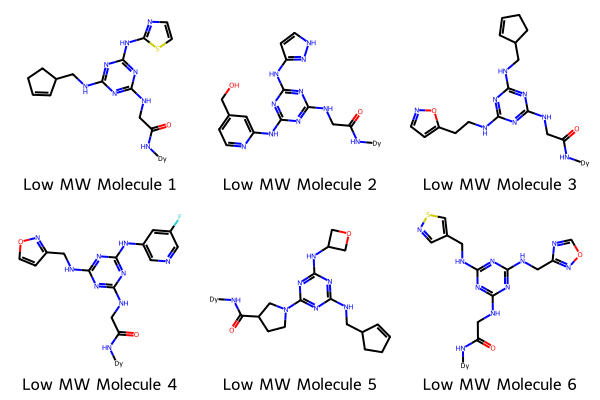

Low Molecular Weight Molecules (Bottom 6)


In [44]:
low_weight_mols = df.nsmallest(6, 'mol_weight')['molecule_smiles'].tolist()
low_weight_labels = [f"Low MW Molecule {i+1}" for i in range(6)]
visualize_and_display_molecules(low_weight_mols, low_weight_labels, "Low Molecular Weight Molecules (Bottom 6)")

# Modelo 

In [58]:
from sklearn.metrics import average_precision_score
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors
import duckdb
from imblearn.over_sampling import SMOTE

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import time
from tqdm import tqdm

In [3]:
train_parquet_path = 'train.parquet/train.parquet'

test_parquet_path = 'test.parquet/test.parquet'

In [4]:
con = duckdb.connect()

# Sample 30,000 rows each for binds = 0 and binds = 1 from train.parquet
query_train = f"""
    (SELECT *
    FROM parquet_scan('{train_parquet_path}')
    WHERE binds = 0
    ORDER BY random()
    LIMIT 30000)
    UNION ALL
    (SELECT *
    FROM parquet_scan('{train_parquet_path}')
    WHERE binds = 1
    ORDER BY random()
    LIMIT 30000)
"""

# Load data into DataFrame
train_df = con.from_query(query_train).df()

# Load test data without sampling
query_test = f"""
    SELECT *
    FROM parquet_scan('{test_parquet_path}')
"""

test_df = con.from_query(query_test).df()

# Close DuckDB connection
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    num_atoms = mol.GetNumAtoms()
    mol_weight = Descriptors.MolWt(mol)
    return num_atoms, mol_weight

# Calculate descriptors for train and test data
train_df['num_atoms'], train_df['mol_weight'] = zip(*train_df['molecule_smiles'].apply(calculate_descriptors))
test_df['num_atoms'], test_df['mol_weight'] = zip(*test_df['molecule_smiles'].apply(calculate_descriptors))

In [9]:
features = ['num_atoms', 'mol_weight']
target = 'binds'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

In [46]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba)
    }

# Split data
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_train.values, y_train.values, test_size=0.95, random_state=42)

# Print data sizes
print(f"Training data size: {len(X_train_np)}")
print(f"Test data size: {len(X_test_np)}")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_np, y_train_np)

# Convert resampled data to tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

Training data size: 3000
Test data size: 57000


In [47]:
# MLP model
class ImprovedMLPModel(nn.Module):
    def __init__(self, num_features, hidden_dim1, hidden_dim2, num_classes):
        super(ImprovedMLPModel, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim1)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Initialize improved MLP model
num_features = X_train_np.shape[1]
hidden_dim1 = 64
hidden_dim2 = 32
num_classes = 1  # Binary classification

model = ImprovedMLPModel(num_features, hidden_dim1, hidden_dim2, num_classes)


positive_weight = torch.tensor([500.0]) 
criterion = nn.BCEWithLogitsLoss(pos_weight=positive_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [48]:
# Train the MLP model
model.train()
mlp_train_start = time.time()
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
mlp_train_time = time.time() - mlp_train_start

# Evaluate MLP model
model.eval()
mlp_predict_start = time.time()
with torch.no_grad():
    output = model(X_test_tensor)
    y_pred = (output > 0.5).float().numpy()
    y_pred_proba = output.numpy()
mlp_predict_time = time.time() - mlp_predict_start

mlp_metrics = evaluate_model(y_test_np, y_pred, y_pred_proba)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


 33%|███▎      | 1/3 [00:02<00:04,  2.44s/it]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


 67%|██████▋   | 2/3 [00:04<00:01,  1.97s/it]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


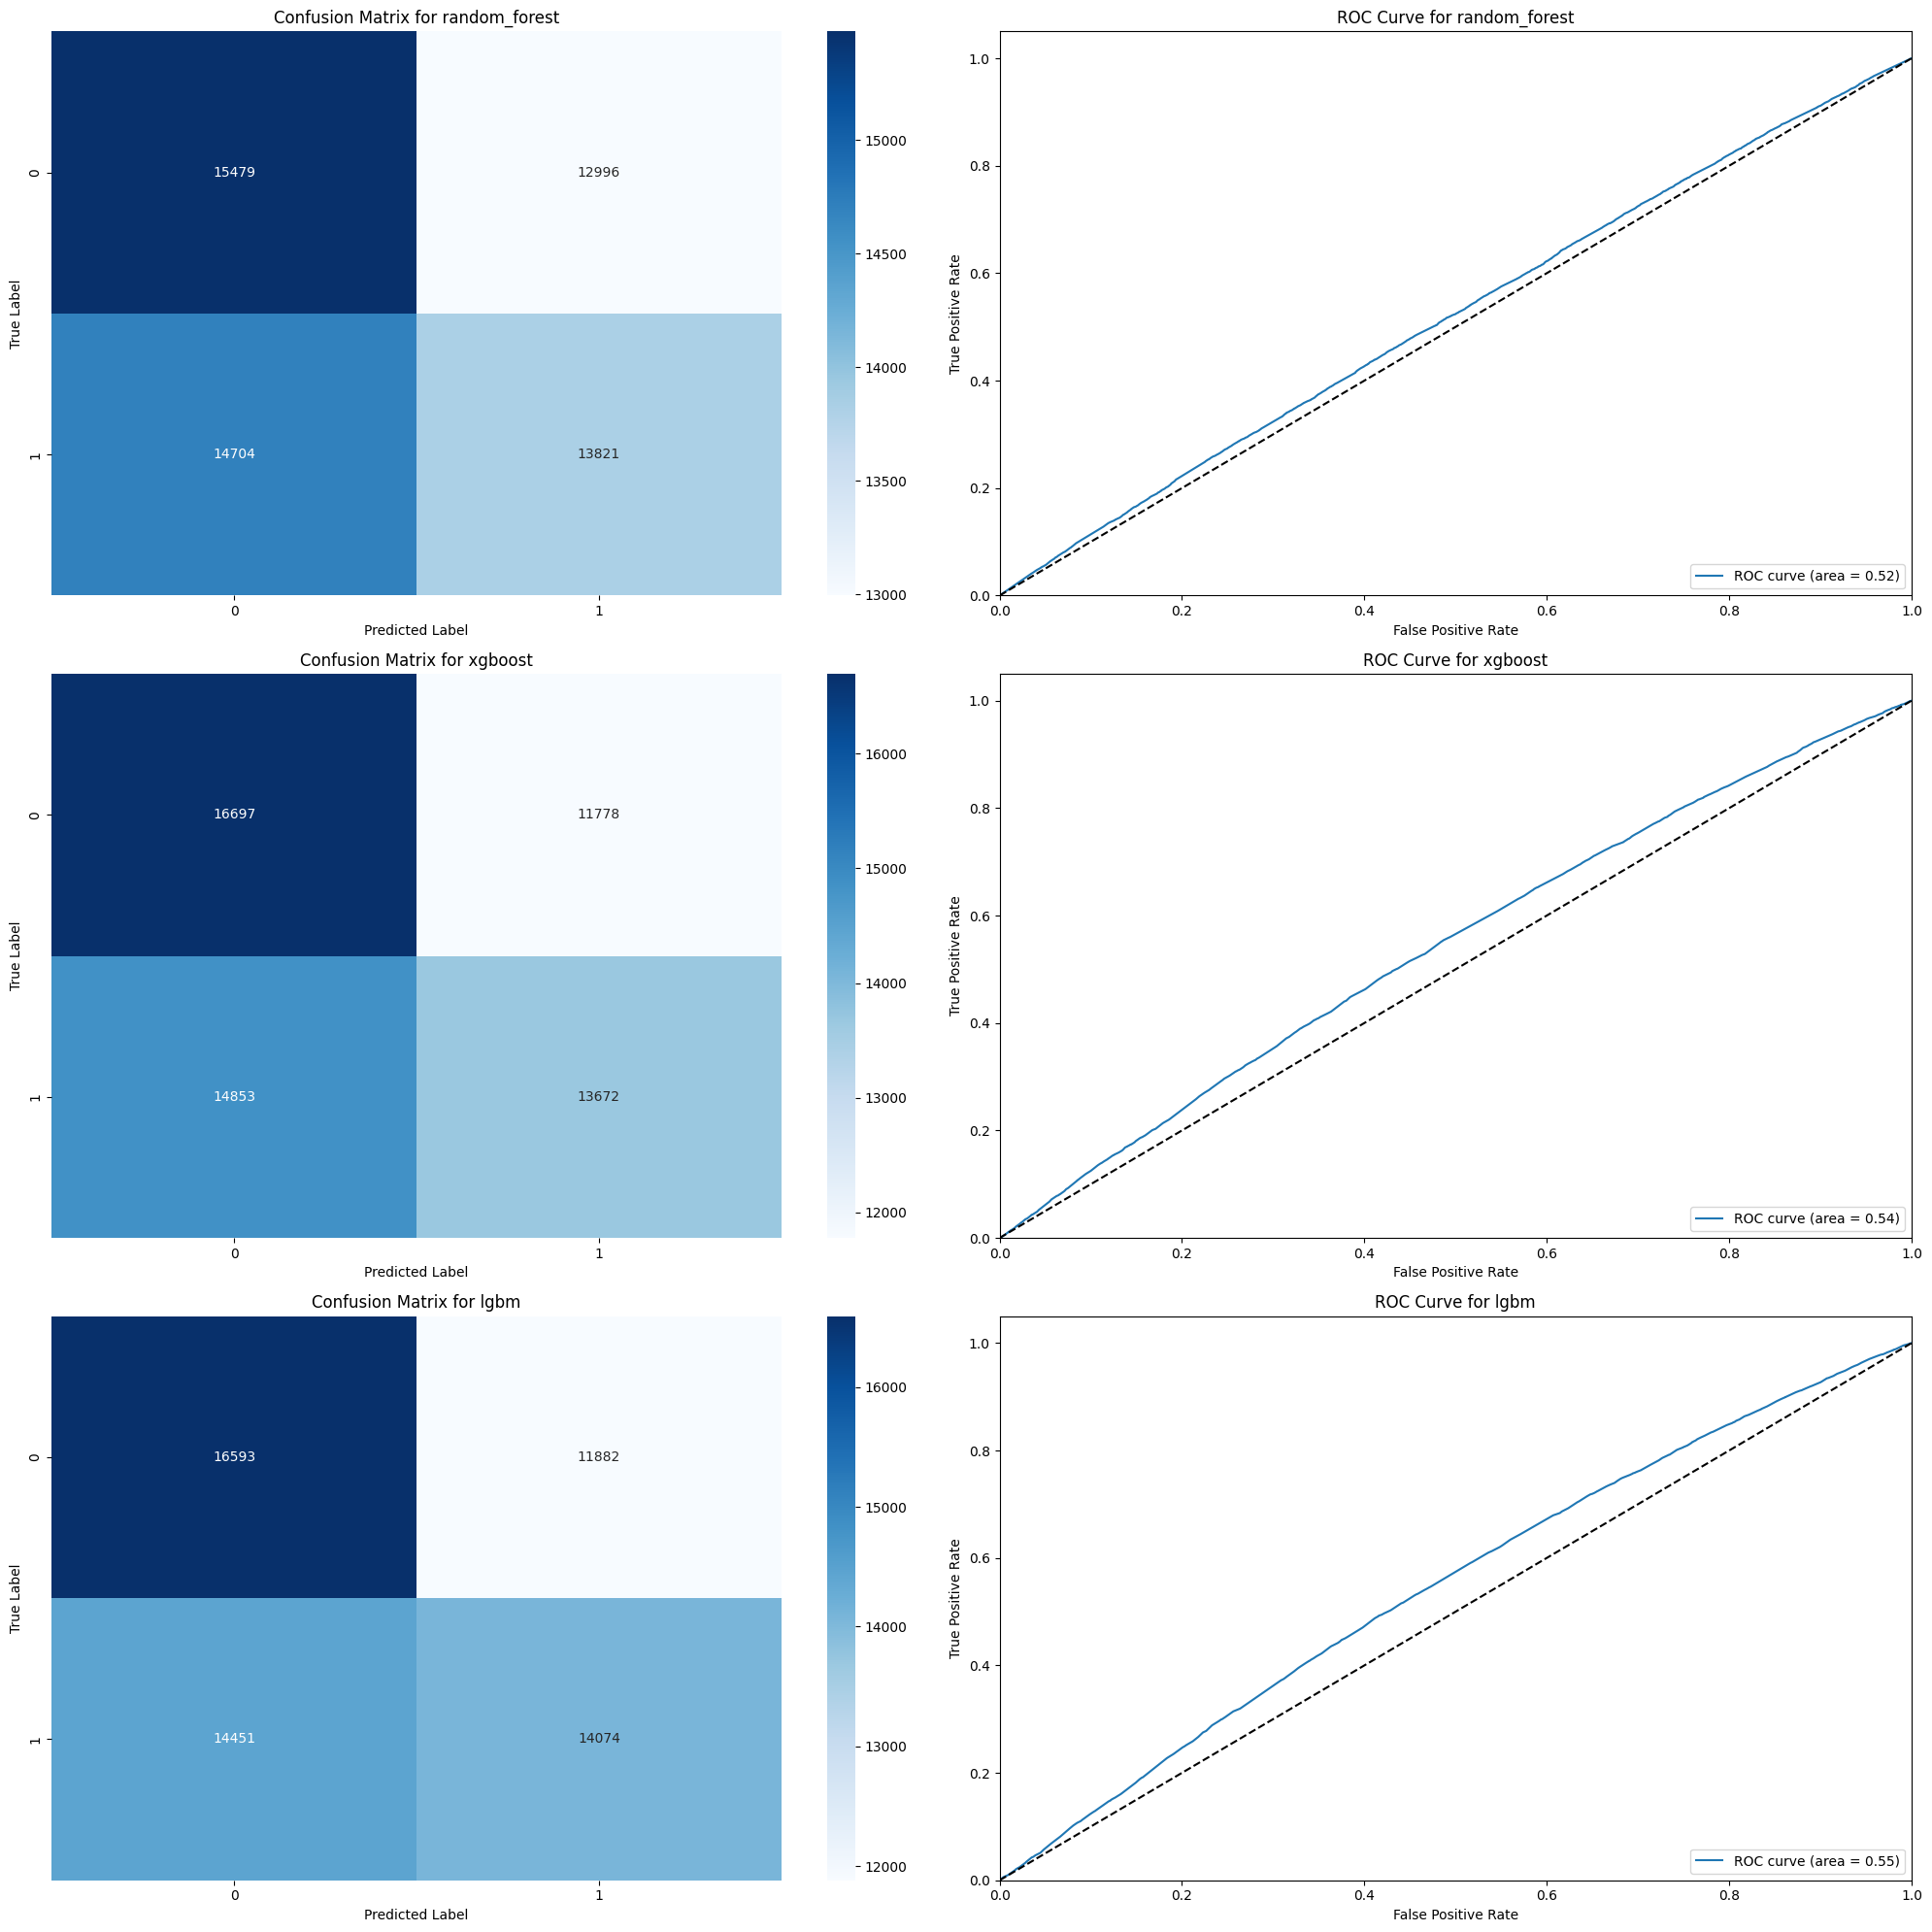

In [59]:

# ---- Modelos con Pipelines y GridSearch ----

pipelines = {
    'random_forest': Pipeline([
        ('random_forest', RandomForestClassifier(random_state=42))
    ]),
    'xgboost': Pipeline([
        ('xgboost', XGBClassifier(random_state=42))
    ]),
    'lgbm': Pipeline([
        ('lgbm', LGBMClassifier(random_state=42))
    ])
}

param_grid = {
    'random_forest': {
        'random_forest__n_estimators': [5, 10, 50],
        'random_forest__max_depth': [20, 30]
    },
    'xgboost': {
        'xgboost__n_estimators': [50, 100],
        'xgboost__max_depth': [3, 6]
    },
    'lgbm': {
        'lgbm__n_estimators': [50, 100],
        'lgbm__max_depth': [3, 6]
    }
}

results = []
trained_models = {}

fig, axes = plt.subplots(3, 2, figsize=(20, 20)) 

for i, model in enumerate(tqdm(pipelines)):
    start_time = time.time()  
    grid_search = GridSearchCV(pipelines[model], param_grid[model], cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1)
    grid_search.fit(X_train_np, y_train_np)  
    end_time = time.time()  

    trained_models[model] = grid_search.best_estimator_

    y_pred = grid_search.best_estimator_.predict(X_test_np)
    y_prob = grid_search.best_estimator_.predict_proba(X_test_np)[:, 1]  
    
    cm = confusion_matrix(y_test_np, y_pred)
    fpr, tpr, _ = roc_curve(y_test_np, y_prob)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test_np, y_pred)
    recall = recall_score(y_test_np, y_pred)
    f1 = f1_score(y_test_np, y_pred)
    
    results.append({
        'Model': model,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc,
        'Best Parameters': grid_search.best_params_,
        'Elapsed Time': end_time - start_time
    })

    # Matriz de confusión
    ax1 = axes[i, 0]  
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax1)
    ax1.set_title(f"Confusion Matrix for {model}")
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # Curva ROC
    ax2 = axes[i, 1]  
    ax2.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve for {model}')
    ax2.legend(loc="lower right")

plt.tight_layout()  
plt.show()

In [53]:
# Train and evaluate XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_train_start = time.time()
xgb_model.fit(X_train_np, y_train_np)
xgb_train_time = time.time() - xgb_train_start

xgb_predict_start = time.time()
xgb_pred = xgb_model.predict(X_test_np)
xgb_pred_proba = xgb_model.predict_proba(X_test_np)[:, 1]
xgb_predict_time = time.time() - xgb_predict_start

xgb_metrics = evaluate_model(y_test_np, xgb_pred, xgb_pred_proba)

# Train and evaluate LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_train_start = time.time()
lgbm_model.fit(X_train_np, y_train_np)
lgbm_train_time = time.time() - lgbm_train_start

lgbm_predict_start = time.time()
lgbm_pred = lgbm_model.predict(X_test_np)
lgbm_pred_proba = lgbm_model.predict_proba(X_test_np)[:, 1]
lgbm_predict_time = time.time() - lgbm_predict_start

lgbm_metrics = evaluate_model(y_test_np, lgbm_pred, lgbm_pred_proba)

# Train and evaluate Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_train_start = time.time()
rf_model.fit(X_train_np, y_train_np)
rf_train_time = time.time() - rf_train_start

rf_predict_start = time.time()
rf_pred = rf_model.predict(X_test_np)
rf_pred_proba = rf_model.predict_proba(X_test_np)[:, 1]
rf_predict_time = time.time() - rf_predict_start

rf_metrics = evaluate_model(y_test_np, rf_pred, rf_pred_proba)

In [ ]:

# ---- Visualización de resultados ----
models = ['XGBoost', 'LightGBM', 'Random Forest']
metrics = [xgb_metrics, lgbm_metrics, rf_metrics]
train_times = [xgb_train_time, lgbm_train_time, rf_train_time]
predict_times = [xgb_predict_time, lgbm_predict_time, rf_predict_time]

# Crear subplots para Confusion Matrix y ROC Curve
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for i, model_name in enumerate(models):
    # Confusion Matrix
    cm = confusion_matrix(y_test_np, [xgb_pred, lgbm_pred, rf_pred][i])
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=axes[i, 0])
    axes[i, 0].set_title(f"Confusion Matrix for {model_name}")
    axes[i, 0].set_ylabel('True Label')
    axes[i, 0].set_xlabel('Predicted Label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_np, [xgb_pred_proba, lgbm_pred_proba, rf_pred_proba][i])
    roc_auc = auc(fpr, tpr)
    axes[i, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[i, 1].plot([0, 1], [0, 1], 'k--')
    axes[i, 1].set_xlim([0.0, 1.0])
    axes[i, 1].set_ylim([0.0, 1.05])
    axes[i, 1].set_xlabel('False Positive Rate')
    axes[i, 1].set_ylabel('True Positive Rate')
    axes[i, 1].set_title(f'ROC Curve for {model_name}')
    axes[i, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# ---- Resultados ----
results = pd.DataFrame({
    'Model': models,
    'Accuracy': [m['accuracy'] for m in metrics],
    'Precision': [m['precision'] for m in metrics],
    'Recall': [m['recall'] for m in metrics],
    'F1-score': [m['f1'] for m in metrics],
    'AUC': [m['auc'] for m in metrics],
    'Train Time': train_times,
    'Predict Time': predict_times
})

In [55]:
# Prepare data for visualization
models = ['MLP', 'XGBoost', 'LightGBM', 'Random Forest']
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
results = np.array([
    [mlp_metrics[m] for m in metrics],
    [xgb_metrics[m] for m in metrics],
    [lgbm_metrics[m] for m in metrics],
    [rf_metrics[m] for m in metrics]
])

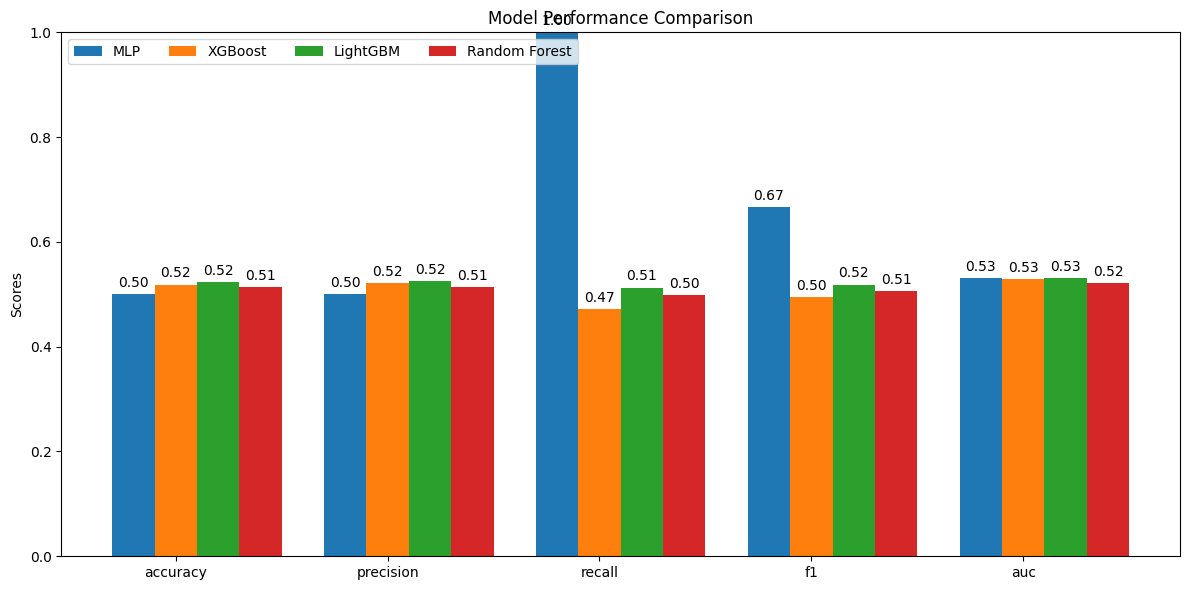

In [56]:
# Create bar plot for performance metrics
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.2
multiplier = 0

for attribute, measurement in zip(models, results):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width, metrics)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [57]:
train_times = [mlp_train_time, xgb_train_time, lgbm_train_time, rf_train_time]
predict_times = [mlp_predict_time, xgb_predict_time, lgbm_predict_time, rf_predict_time]

# Create table for complexity metrics
complexity_data = {
    'Model': models,
    'Training Time (s)': train_times,
    'Prediction Time (s)': predict_times,
}

# Print complexity metrics table
print("\nModel Complexity Metrics:")
print("{:<15} {:<20} {:<20}".format('Model', 'Training Time (s)', 'Prediction Time (s)'))
print("-" * 60)
for model, train_time, pred_time in zip(models, train_times, predict_times):
    print("{:<15} {:<20.4f} {:<20.4f}".format(model, train_time, pred_time))


Model Complexity Metrics:
Model           Training Time (s)    Prediction Time (s) 
------------------------------------------------------------
MLP             3.9731               0.0230              
XGBoost         0.1635               0.0528              
LightGBM        0.0473               0.1345              
Random Forest   0.3665               1.5287              


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import duckdb
from rdkit import Chem
from rdkit.Chem import AllChem

# 1. Carga de datos con DuckDB
con = duckdb.connect(database=':memory:')

# Cargar datos de train desde parquet
parquet_file_path_train = 'train.parquet/train.parquet'
sample_size_train = 200000
con.execute(f"CREATE TABLE train_sample AS SELECT * FROM read_parquet('{parquet_file_path_train}') USING SAMPLE {sample_size_train} ROWS")
df_train = con.execute("SELECT * FROM train_sample").df()

# Cargar datos de test desde parquet
parquet_file_path_test = 'test.parquet/test.parquet'
sample_size_test = 22000
con.execute(f"CREATE TABLE test_sample AS SELECT * FROM read_parquet('{parquet_file_path_test}') USING SAMPLE {sample_size_test} ROWS")
df_test = con.execute("SELECT * FROM test_sample").df()

# 2. Preprocesamiento de SMILES a fingerprints
# Inicializar el generador de huellas de Morgan
morgan_gen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_fingerprint(smiles, size=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return list(morgan_gen.GetFingerprint(mol).ToBitString())
    else:
        return [0] * size  # Retorna una lista de ceros si el SMILES es inválido

# Convertir SMILES a fingerprints para el conjunto de train
print("Convirtiendo SMILES de train a fingerprints...")
tqdm.pandas()
df_train['fingerprint'] = df_train['molecule_smiles'].progress_apply(smiles_to_fingerprint)

# Convertir las cadenas binarias a arreglos de enteros
df_train['fingerprint'] = df_train['fingerprint'].apply(lambda x: [int(bit) for bit in x])

# 3. División en train y validación
X_train = np.array(df_train['fingerprint'].tolist())
y_train = df_train['binds'].values

# Dividir en train y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Preprocesar el conjunto de test (sin la columna 'binds')
df_test['fingerprint'] = df_test['molecule_smiles'].progress_apply(smiles_to_fingerprint)
df_test['fingerprint'] = df_test['fingerprint'].apply(lambda x: [int(bit) for bit in x])
X_test = np.array(df_test['fingerprint'].tolist())
X_test_scaled = scaler.transform(X_test)

# 4. Dataset personalizado
class ChemicalDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        if y is not None:
            self.y = torch.FloatTensor(y)
        else:
            self.y = None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

# Crear datasets
train_dataset = ChemicalDataset(X_train_scaled, y_train)
val_dataset = ChemicalDataset(X_val_scaled, y_val)
test_dataset = ChemicalDataset(X_test_scaled)

# Crear data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, weight_decay = 0.0001):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
        )
    
    def forward(self, x):
        return self.layers(x)


def calculate_roc_auc(y_true, y_predicted):
  return roc_auc_score(y_true, y_predicted)

# Inicializar el modelo
model = MLP(input_size=2048, weight_decay=0.001)

# 6. Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utilizar BCEWithLogitsLoss para mayor estabilidad numérica
criterion = nn.BCEWithLogitsLoss()

# Calcular pesos de clases para manejar el desbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

# Utilizar Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
model.to(device)

print(f"Training on {device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for batch_X, batch_y in train_pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': f"{train_loss/(train_pbar.n+1):.4f}"})
    
    # Validación
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    y_true = []
    y_pred = []  # Add these lines to store true and predicted labels
    with torch.no_grad():
     for batch_X, batch_y in val_pbar:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        val_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        val_pbar.set_postfix({'loss': f"{val_loss/(val_pbar.n+1):.4f}", 'acc': f"{correct/total:.4f}"})

    accuracy = correct / total
    roc_auc = calculate_roc_auc(y_true, y_pred)  

print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}')

# 7. Evaluación final en test (sin etiquetas)
model.eval()
test_pbar = tqdm(test_loader, desc="Final Evaluation (Test set)")
test_predictions = []
with torch.no_grad():
    for batch_X in test_pbar:
        batch_X = batch_X.to(device)
        outputs = model(batch_X).squeeze()
        predicted = torch.sigmoid(outputs).cpu().numpy()
        test_predictions.extend(predicted)

# # Guardar predicciones en un archivo
# df_test['predictions'] = test_predictions
# df_test[['id', 'predictions']].to_csv('test_predictions.csv', index=False)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Convirtiendo SMILES de train a fingerprints...


100%|██████████| 22000/22000 [00:22<00:00, 979.72it/s] 


Training on cpu


Epoch 10/10 [Val]: 100%|██████████| 1250/1250 [00:08<00:00, 139.28it/s, loss=0.1388, acc=0.9931]


Epoch [10/10], Train Loss: 0.0021, Val Loss: 0.1384, Val Accuracy: 0.9931, ROC AUC: 0.5334


Final Evaluation (Test set): 100%|██████████| 688/688 [00:02<00:00, 294.40it/s]
